In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
from datetime import datetime, timezone,timedelta
from collections import Counter
import numpy as np
import matplotlib.patches as patches
from wordcloud import WordCloud

In [2]:
conversation=pd.read_json('conversations.json')

In [3]:
conversation.head()

,title,create_time,update_time,mapping,moderation_results,current_node,plugin_ids,conversation_id,conversation_template_id,gizmo_id,gizmo_type,is_archived,is_starred,safe_urls,default_model_slug,conversation_origin,voice,async_status,disabled_tool_ids,id
0,Change primary camera Linux,2025-01-23 17:58:15.056133032,2025-01-23 18:00:26.101727962,{'aaa12898-0c15-4820-8cb4-a7023f608d2a': {'id'...,[],b2f2c352-3f35-46ef-8ba6-98fc458f56aa,NaN,67928336-da14-8004-91f9-6dfd40fc3700,None,None,None,False,NaN,[],auto,NaN,None,NaN,[],67928336-da14-8004-91f9-6dfd40fc3700
1,AI Associate Cover Letter,2025-01-23 17:03:05.121684074,2025-01-23 17:28:48.073684931,{'aaa16b2f-c0c7-4f3f-a71a-3b30a7c93c2b': {'id'...,[],6c14689e-5c40-4d4c-9194-214e2b57b210,NaN,67927648-e5c4-8004-b43b-4410d6aa34f7,None,None,None,False,NaN,[],auto,NaN,None,NaN,[],67927648-e5c4-8004-b43b-4410d6aa34f7
2,Bluetooth Reset Guide,2025-01-23 11:02:13.780508995,2025-01-23 11:02:38.708734035,{'aaa15412-0248-4df3-8fb9-cf95f1ad7993': {'id'...,[],86ac9947-a636-486b-8afe-2cbb998e938f,NaN,679221b5-8f5c-8004-9e7a-93ddf0839780,None,None,None,False,NaN,[],auto,NaN,None,NaN,[],679221b5-8f5c-8004-9e7a-93ddf0839780
3,Reset Bluetooth Drivers Win,2025-01-23 10:35:34.095171928,2025-01-23 10:35:55.073493004,{'aaa10f65-111c-4259-a756-85776a386149': {'id'...,[],3c22621c-0cb8-48f9-8269-9aaf609ec87e,NaN,67921b75-b908-8004-b300-501a9b57bd06,None,None,None,False,NaN,[],auto,NaN,None,NaN,[],67921b75-b908-8004-b300-501a9b57bd06
4,HCF Calculation Without Recursion,2025-01-23 10:07:57.472731113,2025-01-23 10:09:23.563735962,{'aaa195c1-4074-4f3f-9c31-883ee14219f7': {'id'...,[],f1f9495c-0ea1-400b-92d4-db70acbd54b5,NaN,679214fd-50f4-8004-a926-e04a454c7a8c,None,None,None,False,NaN,[],auto,NaN,None,NaN,[],679214fd-50f4-8004-a926-e04a454c7a8c


In [4]:
conversation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   title                     773 non-null    object        
 1   create_time               773 non-null    datetime64[ns]
 2   update_time               773 non-null    datetime64[ns]
 3   mapping                   773 non-null    object        
 4   moderation_results        773 non-null    object        
 5   current_node              773 non-null    object        
 6   plugin_ids                0 non-null      float64       
 7   conversation_id           773 non-null    object        
 8   conversation_template_id  1 non-null      object        
 9   gizmo_id                  1 non-null      object        
 10  gizmo_type                1 non-null      object        
 11  is_archived               773 non-null    bool          
 12  is_starred            

In [5]:
conversation['create_time'].head(2)

0   2025-01-23 17:58:15.056133032
1   2025-01-23 17:03:05.121684074
Name: create_time, dtype: datetime64[ns]

In [6]:
local_tz = "Asia/Kolkata"
time=[]
conv=conversation.copy()

In [7]:
conversation['create_time'] = pd.to_datetime(conversation['create_time'])
conversation['create_time'] = conversation['create_time'].dt.tz_localize('UTC')
conversation['local_time'] = conversation['create_time'].dt.tz_convert(local_tz)
local_datetime_list = conversation['local_time'].dt.to_pydatetime().tolist()

/tmp/ipykernel_10288/2756090439.py:4: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  local_datetime_list = conversation['local_time'].dt.to_pydatetime().tolist()


In [8]:
print(local_datetime_list[0])

2025-01-23 23:28:15.056133+05:30


In [9]:
def create_heatmaps_for_all_years(local_datetime_list):
    available_years = sorted({dt.year for dt in local_datetime_list})

    for year in available_years:
        just_dates = [dt.date() for dt in local_datetime_list if dt.year == year]
        date_counts = Counter(just_dates)

        start_date = datetime(year, 1, 1).date()
        end_date = datetime(year, 12, 31).date()
        total_days = (end_date - start_date).days + 1
        date_range = [start_date + timedelta(days=i) for i in range(total_days)]

        data = []
        for date in date_range:
            week = ((date - start_date).days + start_date.weekday()) // 7
            day_of_week = date.weekday()
            count = date_counts.get(date, 0)
            data.append((week, day_of_week, count))

        if date_counts:
            max_count_date = max(date_counts, key=date_counts.get)
            max_count = date_counts[max_count_date]
            p90_count = np.percentile(list(date_counts.values()), 90)
        else:
            max_count_date = "N/A"
            max_count = 0
            p90_count = 1  

        plt.figure(figsize=(15, 8))
        ax = plt.gca()
        ax.set_aspect('equal')
        norm = plt.Normalize(vmin=0, vmax=p90_count)

        for week, day_of_week, count in data:
            color = plt.cm.Purples(norm(count)) if count > 0 else '#D9EAFD'
            rect = patches.Rectangle((week, day_of_week), 1, 1, linewidth=0.5, edgecolor='white', facecolor=color)
            ax.add_patch(rect)

        month_starts = [start_date + timedelta(days=i) for i in range(total_days)
                        if (start_date + timedelta(days=i)).day == 1]
        for month_start in month_starts:
            week = (month_start - start_date).days // 7
            plt.text(week + 0.5, 8, month_start.strftime('%b'), ha='center', va='center', fontsize=12,
                     color='red')

        ax.set_xlim(-0.5, len(date_range) // 7 + 0.5)
        ax.set_ylim(-0.5, 7.5)
        plt.xticks([])
        plt.yticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=12)
        plt.gca().invert_yaxis()

        plt.title(
            f'{year} Conversation Heatmap\n'
            f'Total Conversations: {sum(date_counts.values())}, Most Active Day: {max_count_date} ({max_count} convos)',
            fontsize=16, pad=20,color='#441752')

        plt.tight_layout()
        plt.savefig(f'heatmap{year}.png',bbox_inches='tight')
        plt.show()
        


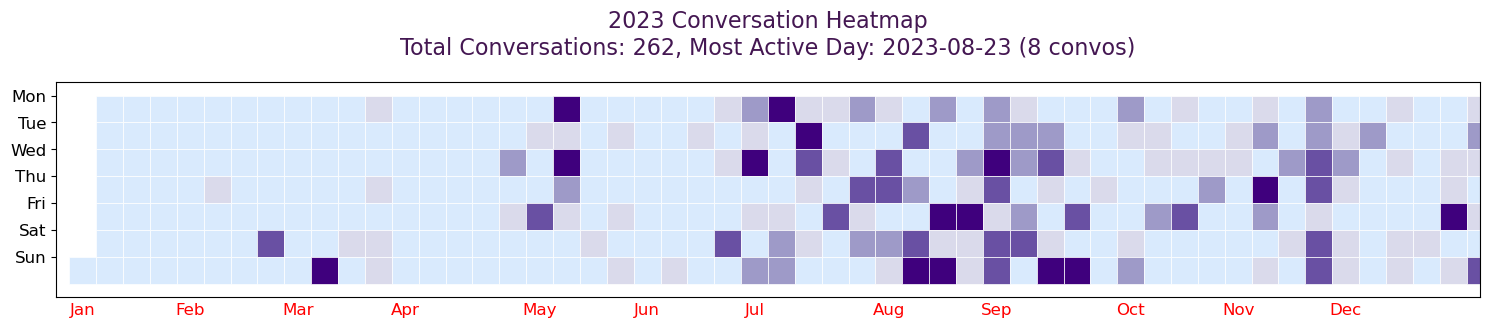

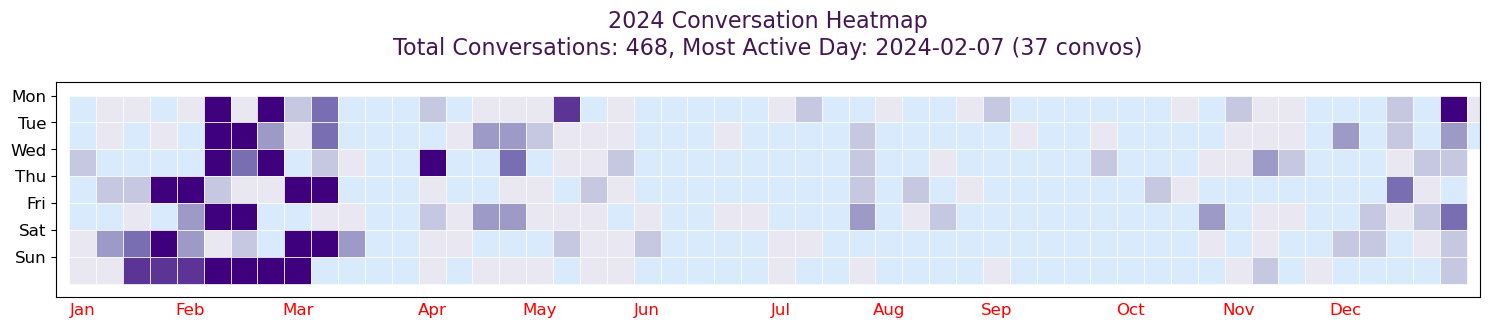

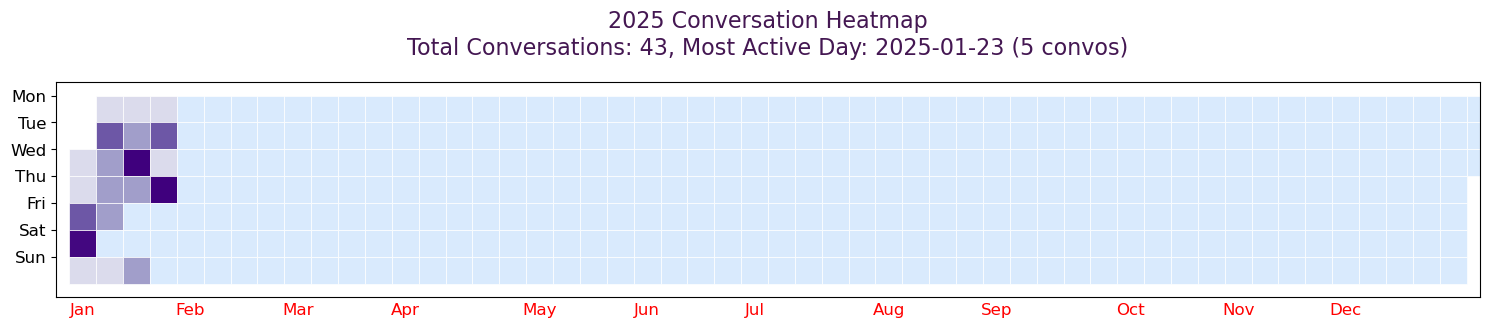

In [10]:
create_heatmaps_for_all_years(local_datetime_list)

In [11]:
text_to_exclude = ['new chat', 'chat new', 'chat', 'chatnew']
cleaned_data = conversation[~conversation['title'].str.lower().isin(text_to_exclude)]['title']

In [12]:
words_data = ''.join(cleaned_data)

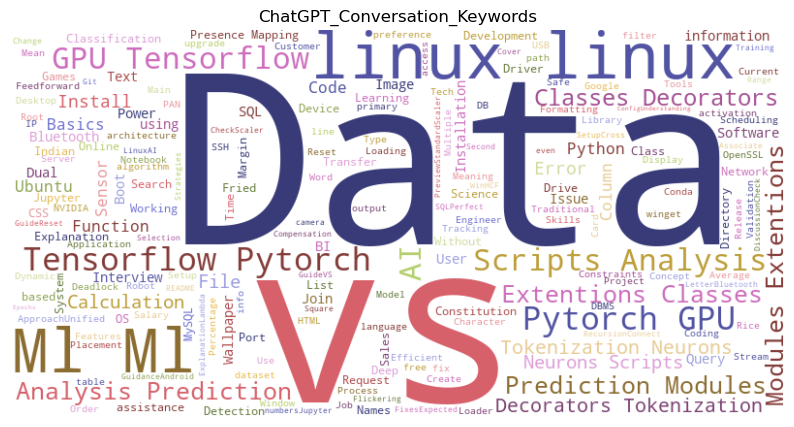

In [17]:
wordcloud =WordCloud(width=800, height=400, colormap='tab20b',background_color='white').generate(words_data)
plt.figure(figsize=(10, 6))
plt.title('ChatGPT_Conversation_Keywords')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('WORD CLOUD OF CHAT GPT')
plt.show()